<img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="240" height="360" />
# Machine Learning project on FIFA 2018 Statistics

## Index: 

1. Problem Statement <br>

2. Exploratory Data Analysis <br>
a. Feature Engineering <br>
b. Breaking the dataset into two groups(Group Stage and Tournament)<br>
b. Graphs <br>

3. Data Organising <br>
a. Dealing with Categorical Variables <br> 

4. Training and Classification <br> 
a. Decision Tree <br> 
b. Random Forests Classifier <br>
c. Logistic Regression <br> 

5. Observation

## 1. Problem Statement

Predict the MoMs in the tournament by using group stage data.<br>
Machine learning Alogrithm. <br>
1) Decision Tree(sklearn) <br>
2) Random Forest(sklearn)<br>
3) Linear Regression

## 2. Exploratory Data Analysis

In [6]:
import numpy as np                                                 # Implemennts milti-dimensional array and matrices
import pandas as pd                                                # For data manipulation and analysis
import pandas_profiling
import matplotlib.pyplot as plt                                    # Plotting library for Python programming language and it's numerical mathematics extension NumPy
import seaborn as sns                                              # Provides a high level interface for drawing attractive and informative statistical graphics
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

from subprocess import check_output

In [7]:
data = pd.read_csv("https://raw.githubusercontent.com/insaid2018/Term-2/master/Projects/FIFA%202018%20Statistics.csv")

## a. Feature Engineering

In [9]:
data.rename(columns={'Goal Scored': 'Goal_Scored', 'Ball Possession %':'Ball_Possession', 'Pass Accuracy %':'Pass_Accuracy', 'Distance Covered (Kms)':'Distance_Covered', 'Fouls Committed':'Fouls_Committed','Man of the Match':'MoM'},inplace=True)
data.sample(3)

,Date,Team,Opponent,Goal_Scored,Ball_Possession,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,MoM,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
8,16-06-2018,France,Australia,2,51,12,5,4,3,5,...,1,0,0,Yes,58.0,Group Stage,No,0,NaN,NaN
104,02-07-2018,Brazil,Mexico,2,47,21,10,7,4,8,...,2,0,0,Yes,51.0,Round of 16,No,0,NaN,NaN
7,15-06-2018,Spain,Portugal,3,61,12,5,5,2,5,...,1,0,0,Yes,24.0,Group Stage,No,0,NaN,NaN


### Plotting Group Stage Data

Out of these features: 

Date,PSO, Goals in PSO, Own goals, Own goal Time can be dropped. 
Team and Opponent contain names of countries. 
Man of the Match(MoM)  have values in Yes or No. 
Round has 6 different values. 
I'll deal with Team and Opponent separately

In [10]:
dropset = ['Date','PSO','Goals in PSO', 'Own goals','Own goal Time']
data = data.drop(dropset,axis=1)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 22 columns):
Team                128 non-null object
Opponent            128 non-null object
Goal_Scored         128 non-null int64
Ball_Possession     128 non-null int64
Attempts            128 non-null int64
On-Target           128 non-null int64
Off-Target          128 non-null int64
Blocked             128 non-null int64
Corners             128 non-null int64
Offsides            128 non-null int64
Free Kicks          128 non-null int64
Saves               128 non-null int64
Pass_Accuracy       128 non-null int64
Passes              128 non-null int64
Distance_Covered    128 non-null int64
Fouls_Committed     128 non-null int64
Yellow Card         128 non-null int64
Yellow & Red        128 non-null int64
Red                 128 non-null int64
MoM                 128 non-null object
1st Goal            94 non-null float64
Round               128 non-null object
dtypes: float64(1), int64(17), o

 1. All data types are numeric except for Date, Team, Opponent and MoM(Man of the Match).
 2. Let's convert the MoM data to numerical type and 1st Goal to categorical type respectively.

In [12]:
# Coverting to Numeric
# 1 = Yes
# 0 = No
data.MoM = data.MoM.replace(['Yes','No'],[1,0])

In [13]:
# Categorical data
data.rename(columns={'1st Goal': 'First_goal_time'},inplace=True)
data.First_goal_time = data.First_goal_time.fillna(0)
data.First_goal_time.loc[(data.First_goal_time >= 1) & (data.First_goal_time < 15)] = 1
data.First_goal_time.loc[(data.First_goal_time >= 15) & (data.First_goal_time < 30)] = 2
data.First_goal_time.loc[(data.First_goal_time >= 30) & (data.First_goal_time < 45)] = 3
data.First_goal_time.loc[(data.First_goal_time >= 45) & (data.First_goal_time < 60)] = 4
data.First_goal_time.loc[(data.First_goal_time >= 60) & (data.First_goal_time < 75)] = 5
data.First_goal_time.loc[data.First_goal_time >= 75] = 6

data.sample(1)

,Team,Opponent,Goal_Scored,Ball_Possession,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,...,Pass_Accuracy,Passes,Distance_Covered,Fouls_Committed,Yellow Card,Yellow & Red,Red,MoM,First_goal_time,Round
72,Denmark,France,0,38,5,1,2,2,4,1,...,72,305,106,10,1,0,0,0,0.0,Group Stage


Creating a feature of goals conceded by a team in a match using goals scored by the opposition

In [14]:
gc = np.array([], dtype = 'int')
for i in range(0, 128, 2):
    gc = np.append(gc, data.loc[i+1, "Goal_Scored"])
    gc = np.append(gc, data.loc[i, "Goal_Scored"])
    
data.insert(3, "Goal Conceded", pd.Series(gc))

Creating a feature of who won the match using goals scored and goals conceded. 
Attributes: Won, Lost, Draw (0, 1, 2) to keep no. of categories low

In [15]:
conditions = [(data["Goal_Scored"] > data["Goal Conceded"]), (data["Goal_Scored"] == data["Goal Conceded"]), (data["Goal_Scored"] < data["Goal Conceded"])]
result = np.array([0, 1, 2], dtype = 'int')
data.insert(4, "Result", pd.Series(np.select(conditions, result, default = -1)))

data.sample(3)

,Team,Opponent,Goal_Scored,Goal Conceded,Result,Ball_Possession,Attempts,On-Target,Off-Target,Blocked,...,Pass_Accuracy,Passes,Distance_Covered,Fouls_Committed,Yellow Card,Yellow & Red,Red,MoM,First_goal_time,Round
37,Saudi Arabia,Uruguay,0,1,2,53,8,3,3,2,...,86,590,100,13,0,0,0,0,0.0,Group Stage
84,Serbia,Brazil,0,2,2,44,10,1,5,4,...,78,467,114,13,3,0,0,0,0.0,Group Stage
63,Colombia,Poland,3,0,0,55,13,3,5,5,...,82,514,108,10,0,0,0,1,3.0,Group Stage


## b. Breaking the dataset into two groups(Group Stage and Tournament)

In [16]:
# Group Stage Data
Group_Stage = data[data.Round == 'Group Stage']
Group_Stage = Group_Stage.drop('Round',axis=1)

# Tournament Data
Tournament = data[data.Round != 'Group Stage']
Tournament = Tournament.drop('Round',axis=1)

## c. Graphs

Barplot to identify the MoM in Group Stage as per the country

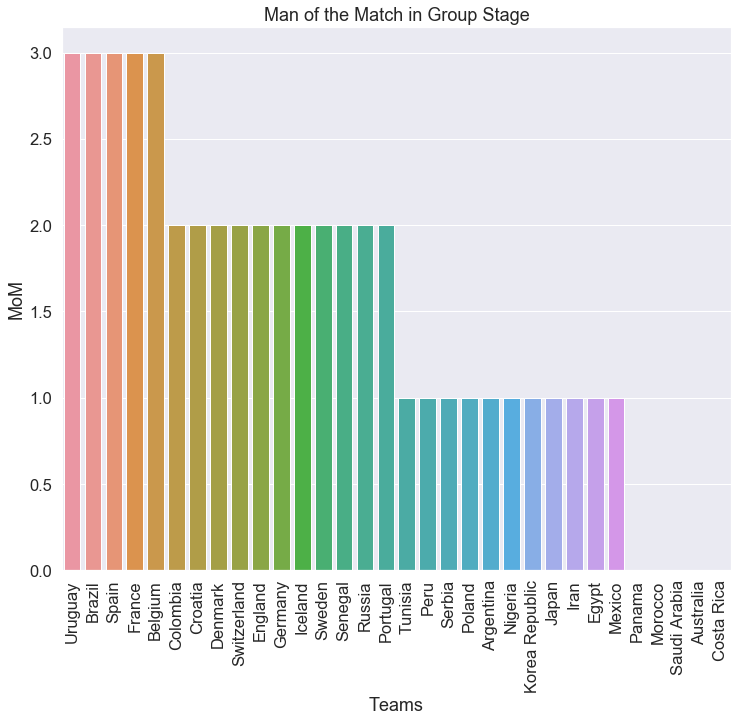

In [17]:
mom = Group_Stage.groupby('Team')['MoM'].sum().reset_index().sort_values(by=('MoM'),ascending=False)

plt.figure(figsize = (12, 10), facecolor = None)
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
plot1 = sns.barplot(x="Team", y="MoM", data=mom)

plot1.set_xticklabels(mom['Team'], rotation=90, ha="center")
plot1.set(xlabel='Teams',ylabel='MoM')
plot1.set_title('Man of the Match in Group Stage')
plt.show()

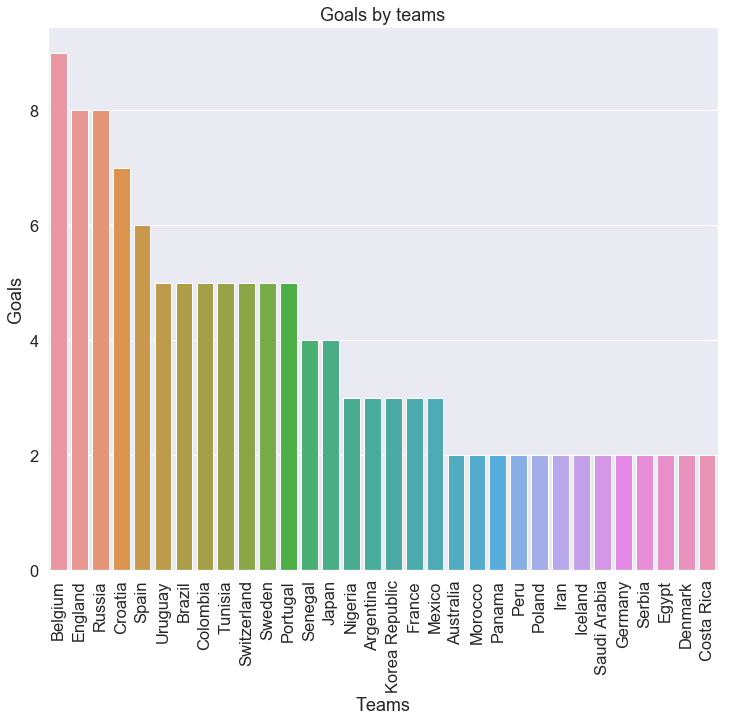

In [124]:
goals = Group_Stage.groupby('Team')['Goal_Scored'].sum().reset_index().sort_values(by=('Goal_Scored'),ascending=False)

plt.figure(figsize = (12, 10), facecolor = None)
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
plot1 = sns.barplot(x="Team", y="Goal_Scored", data=goals)

plot1.set_xticklabels(goals['Team'], rotation=90, ha="center")
plot1.set(xlabel='Teams',ylabel='Goals')
plot1.set_title('Goals by teams')
plt.show()

#### Finding the correleation using Heatmap(Correlations)

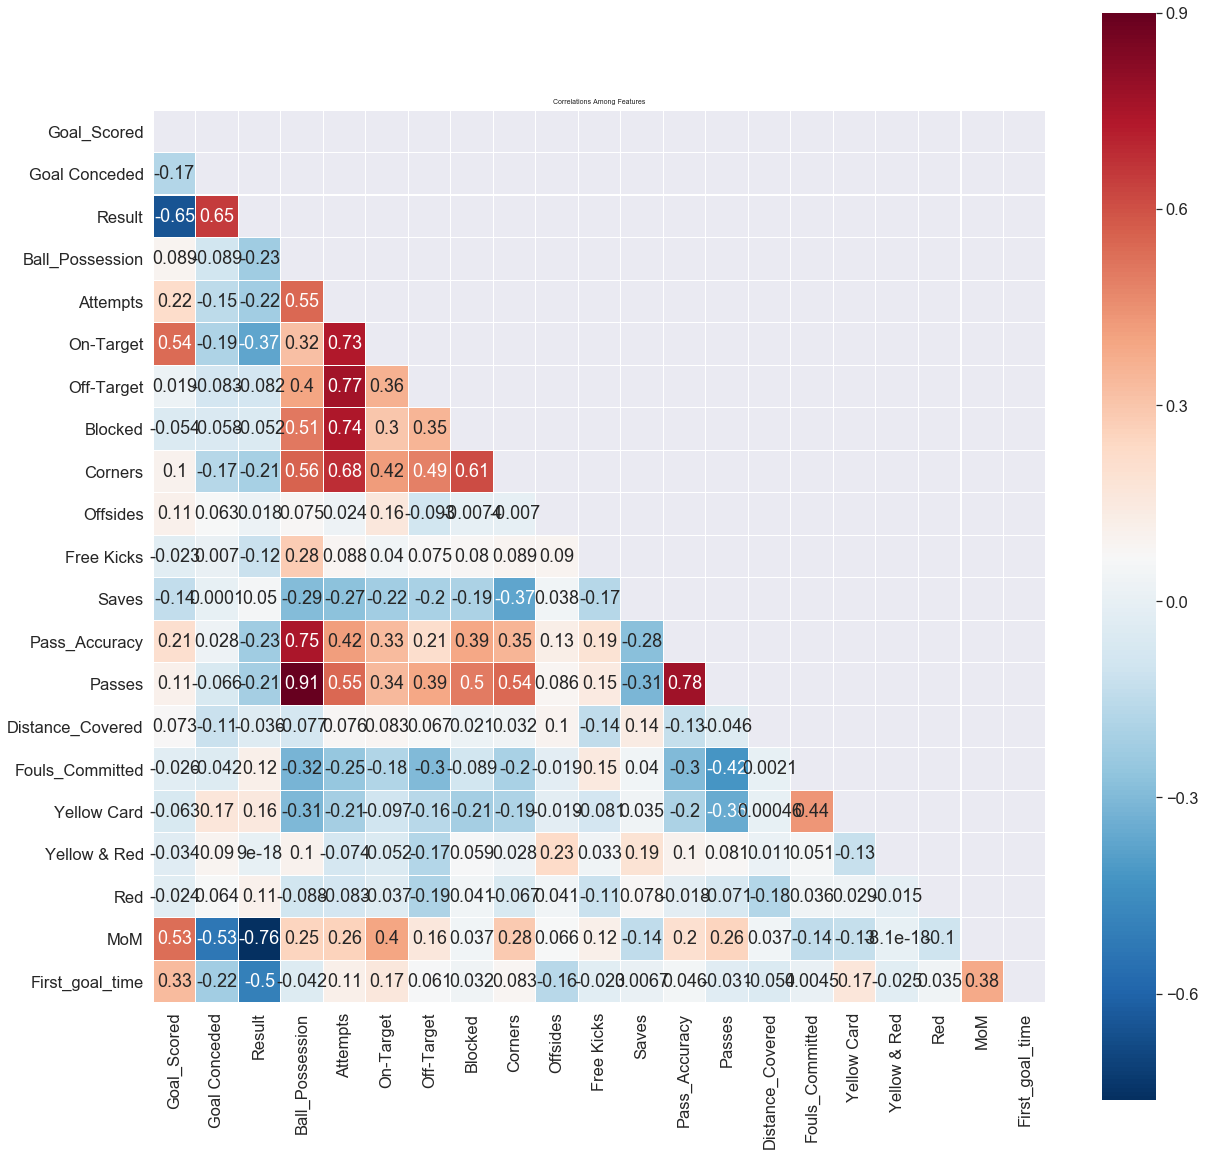

In [18]:
mask = np.zeros_like(Group_Stage.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (20,20))
sns.heatmap(Group_Stage.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 7)
plt.show()

Man of the Match' is highly correlated with 'Goal Scored', 'On-Target', 'Corners', 'Attempts', 'free Kicks', 'Yellow Card', 'red', 'Fouls.<br>
Committed', 'Own goal Time’<br>
Own goal time is twins of 'Ball possession %', and Passes, pass Accuracy <br>
Pass HCW Pass Accuracy %.<br>
These features have least or no correlation with 'Man of the Match'
['Blocked', 'OffSides', 'Saves','Distance Covered (Kms)', 'Yellow & Red', '1st Goal', 'Goals in PSO'] <br>
These features will not have impact on our analysis and thus, holding them or retaining them is our choice.


## Pairplot

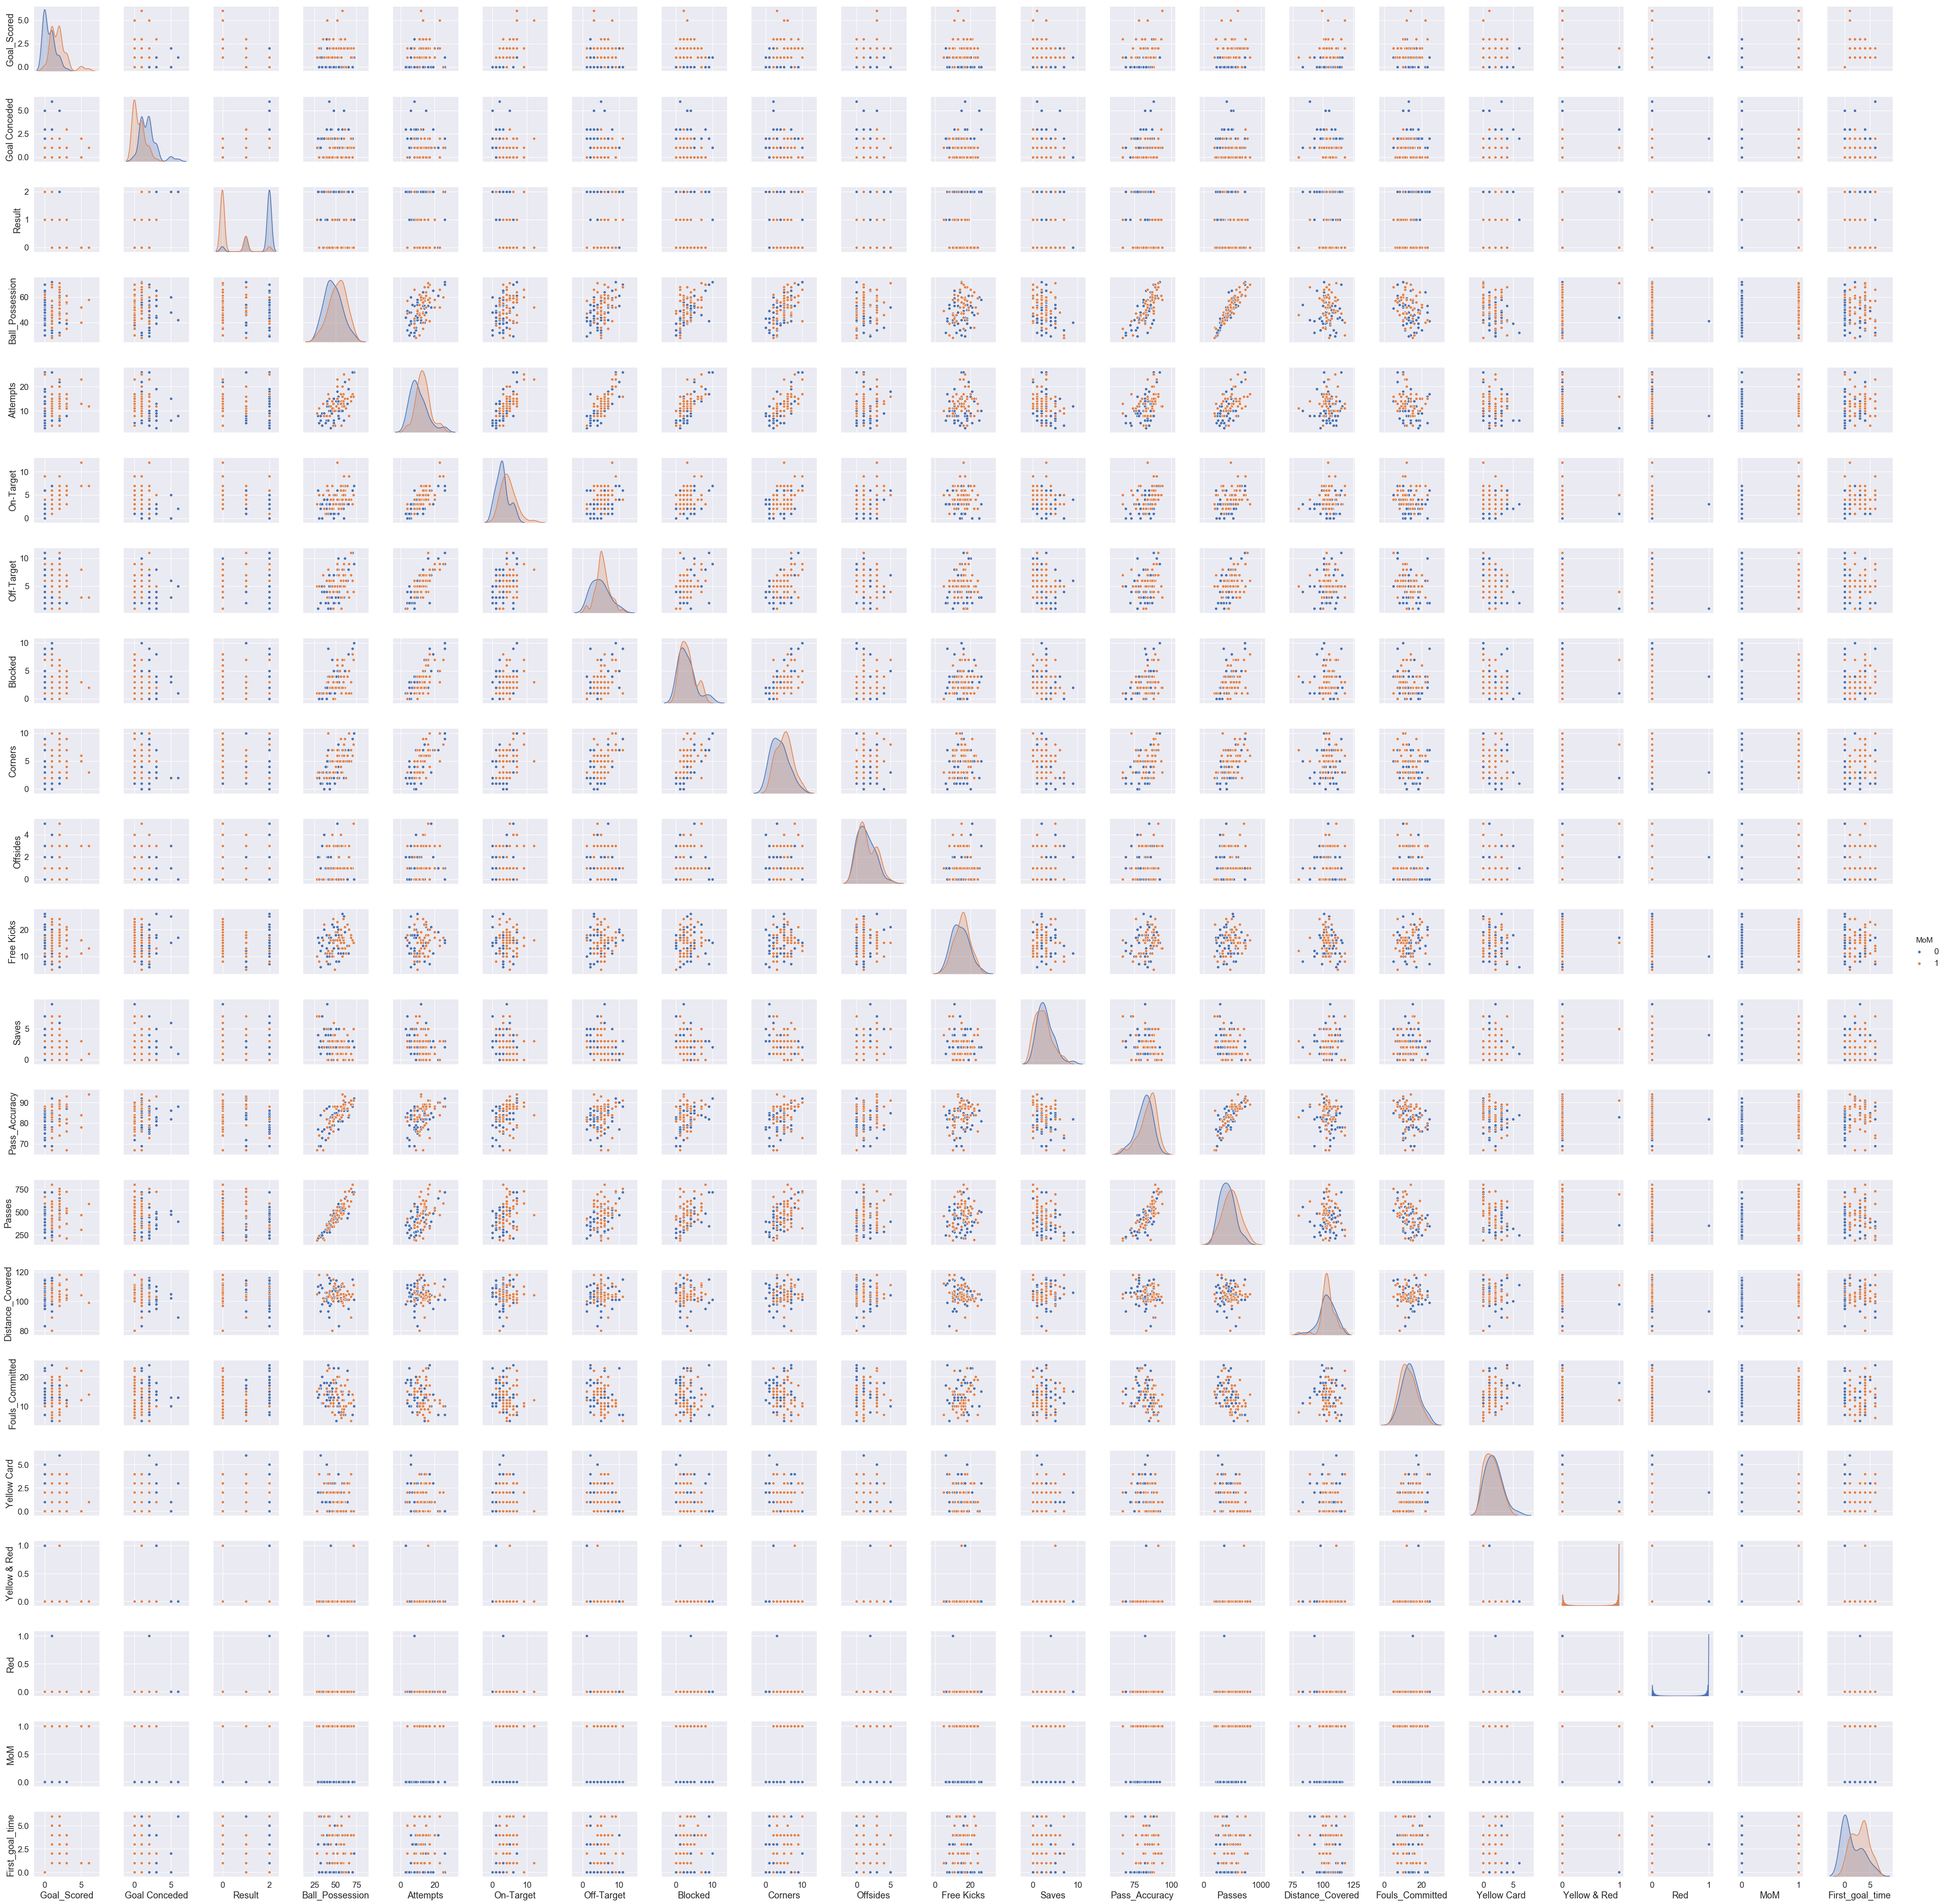

In [19]:
sns.pairplot(Group_Stage, hue='MoM')
plt.show()

As I can notice 'Attempts' is linearly proportional to 'On-Target' and 'Corners' <br>
'Corners' and 'On-Targets' are also linearly positively proportional

## Boxplot

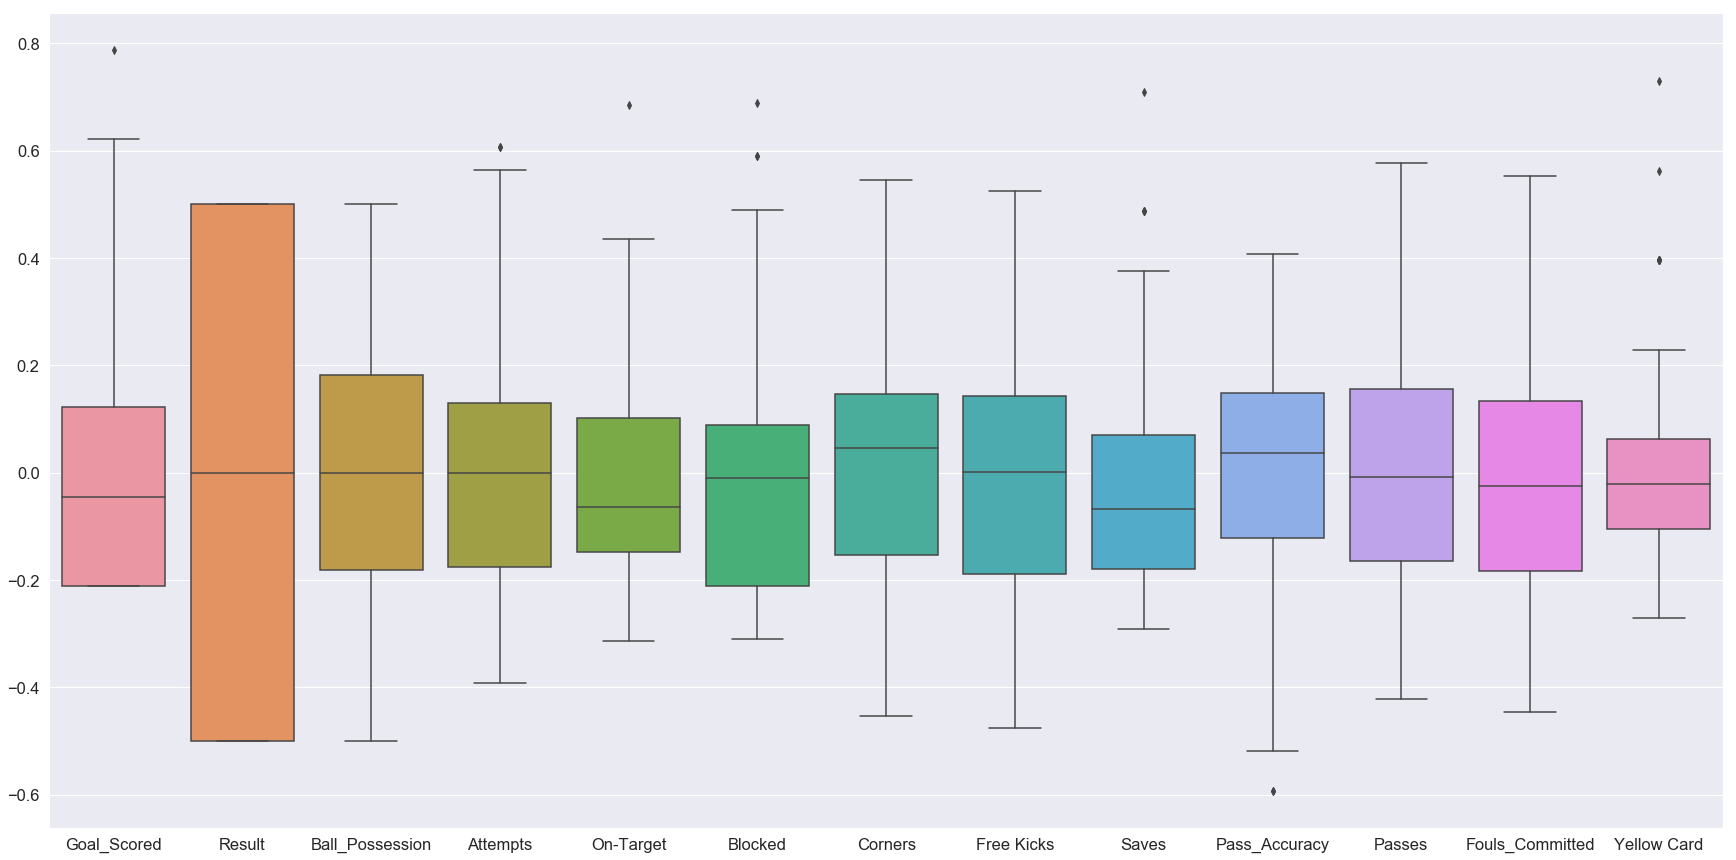

In [20]:
sub = ['Goal_Scored','Result','Ball_Possession','Attempts','On-Target','Blocked','Corners','Free Kicks','Saves','Pass_Accuracy','Passes','Fouls_Committed','Yellow Card']
temp = Group_Stage[sub]
# Normalize Tournament Data(Min-Max Scale)
data_norm = (temp - temp.mean()) / (temp.max() - temp.min())
plt.figure(figsize=(30,15))
sns.boxplot(data = data_norm)
plt.show()

From the boxplot also we can say that Result field is the most important varaible as compare to others.<br>
Also we can see that we have outliers for Goal_Scored, Attempts, Blocked, Saves,Pass_Accuracy, Yellow card variables.

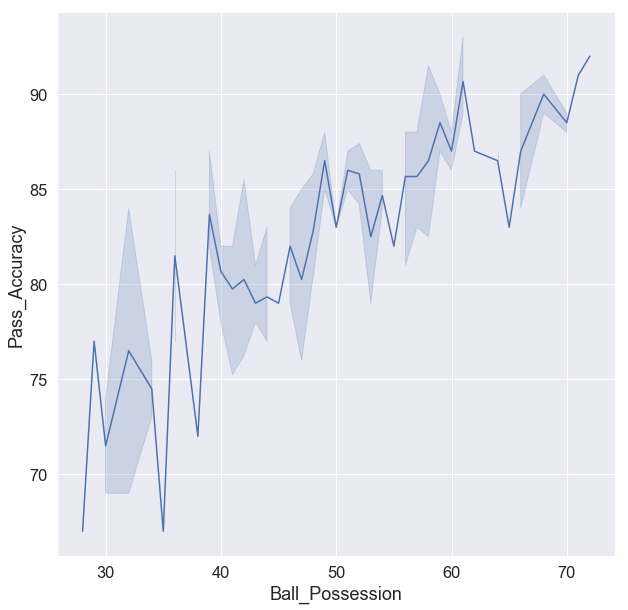

In [21]:
plt.figure(figsize = (10,10))
sns.lineplot(x='Ball_Possession', y='Pass_Accuracy', data=Group_Stage)
plt.show()

### Joint Plot


<Figure size 720x720 with 0 Axes>

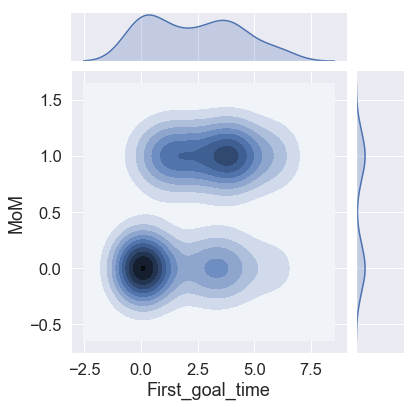

In [22]:
plt.figure(figsize = (10,10))
sns.jointplot(x='First_goal_time', y='MoM', data=Group_Stage, kind='kde')
plt.xticks(np.arange(6), ('None', '1~15', '15~30', '30~45', '45~70', '70~90'), fontsize=10, rotation=90)
plt.show()

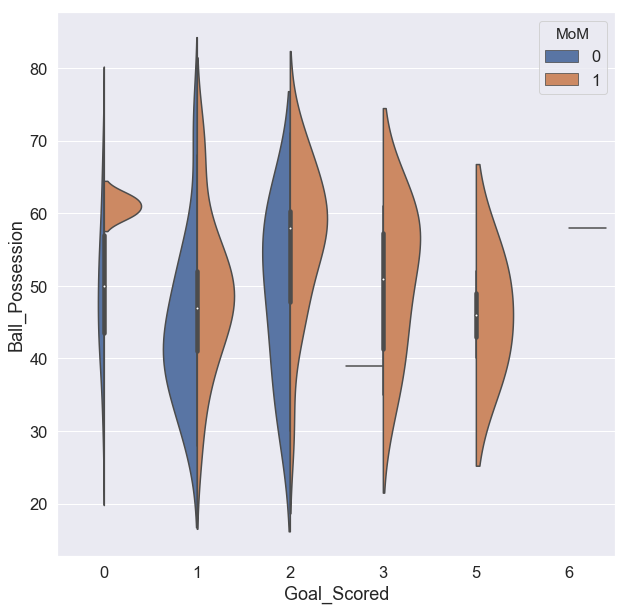

In [23]:
plt.figure(figsize = (10,10))
sns.violinplot(x='Goal_Scored', y='Ball_Possession', hue='MoM', data=Group_Stage, split=True)
plt.show()

The distribution 'Goal Scored' and 'Ball Possession ' differ based on which team won Man of the Match. We can feed it into classification models, expecting to see these variable relationships come into play¶

## 3. Data Organising

### Dealing with Categorical Variables

In [24]:
Group_Stage["Team"] = Group_Stage["Team"].astype('category').cat.codes
Group_Stage["Opponent"] = Group_Stage["Opponent"].astype('category').cat.codes

In [25]:
Group_Stage.head(1)

,Team,Opponent,Goal_Scored,Goal Conceded,Result,Ball_Possession,Attempts,On-Target,Off-Target,Blocked,...,Saves,Pass_Accuracy,Passes,Distance_Covered,Fouls_Committed,Yellow Card,Yellow & Red,Red,MoM,First_goal_time
0,23,24,5,0,0,40,13,7,3,3,...,0,78,306,118,22,0,0,0,1,1.0


## 4. Training and Classification 

### MoM Prediction in the tournament¶


In [38]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import GridSearchCV as gs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [27]:
category = ['Goal_Scored','First_goal_time','Ball_Possession','Attempts','On-Target','Blocked','Corners','Offsides','Free Kicks','Saves','Pass_Accuracy','Passes','Distance_Covered','Fouls_Committed']
Group_Stage = data[data.Round == 'Group Stage']
Tournament = data[data.Round != 'Group Stage']

# Train Data
temp = Group_Stage[category].values.reshape((96, 14))

Y = Group_Stage['MoM'].values.reshape((96, 1))

n = int(len(temp)/2)
#print(n)
x_train = np.zeros((n,14))
y_train = np.zeros((n,1))

# Selecting home team data revised by the proportion with each opponent
for i in range(n): 
    x_train[i,0] = temp[2*i,0] - temp[2*i+1,0] # On a goal difference
  # print(x_train[i,0])
    x_train[i,1] = temp[2*i,1] - temp[2*i+1,1] # First Goal Time value
    x_train[i,2:] = temp[2*i,2:] / (temp[2*i,2:] + temp[2*i+1,2:]) * 100 # Proportion
    y_train[i] = Y[2*i] 
# print(Y[2*i])

In [28]:
# Test Data
test = Tournament[category].values.reshape((32, 14))
Y_real = Tournament['MoM'].values.reshape((32, 1))

m = int(len(test)/2)

x_test = np.zeros((m,14))
y_test = np.zeros((m,1))

for i in range(m):
    x_test[i,0] = test[2*i,0] - test[2*i+1,0]
    x_test[i,1] = test[2*i,1] - test[2*i+1,1]
    x_test[i,2:] = test[2*i,2:] = test[2*i,2:] / (test[2*i,2:] + test[2*i+1,2:]) * 100
    y_test[i] = Y_real[2*i]

In [29]:
# Replaced NaN with zero
x_train = np.nan_to_num(x_train)
x_test = np.nan_to_num(x_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(48, 14) (48, 1) (16, 14) (16, 1)


# Decision Tree

In [30]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=3, min_samples_leaf=5) 
clf_gini.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

### Function to calculate Accuracy for the results¶

In [31]:

def acc(real, pred):
    count = 0
    m = int(len(real)/2)
    for j in range(m):
        if real[j] == pred[j]:
            count = count + 1

    return print(100*count/m,'%')

In [32]:
y_pred = clf_gini.predict(x_test) 
print("Predicted values:") 
print(y_pred) 
    
acc(y_test, y_pred)

Predicted values:
[1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
87.5 %


In [33]:
scores = cross_val_score(clf_gini, x_train, y_train, cv=5)
scores 

array([0.81818182, 0.8       , 0.66666667, 0.77777778, 0.66666667])

# Random Forest

In [39]:
rand_for = rf()

grid = {'n_estimators': [5, 10, 15, 20, 30, 50, 100, 200, 500],
        'max_depth' : [None, 2, 3, 5, 10, 20],
        'criterion': ['gini', 'entropy'],
        'random_state' : [69]}

grid_rand = gs(rand_for, grid, cv = 10)

grid_rand.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 15, 20, 30, 50, 100, 200, 500], 'max_depth': [None, 2, 3, 5, 10, 20], 'criterion': ['gini', 'entropy'], 'random_state': [69]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
def model_output(grid_model):
    """Outputs the best mean cross validation score, the test set accuracy and the parameters of a gridsearch"""
    print('Best mean CV accuracy: ', grid_model.best_score_)
    print('Holdout test set accuracy: ', accuracy_score(grid_model.best_estimator_.predict(x_test), y_test))
    print('Best parameters: ', grid_model.best_params_)

In [43]:
model_output(grid_rand)

Best mean CV accuracy:  0.875
Holdout test set accuracy:  0.75
Best parameters:  {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 15, 'random_state': 69}


The random forest performed the best (looking at CV error)! Let's see which variables played a role in our best predictor

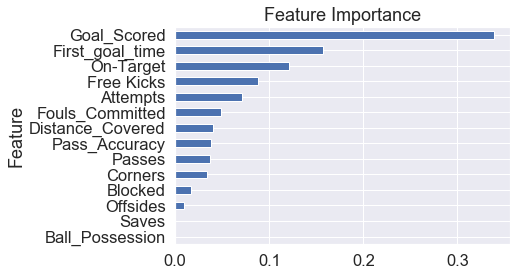

In [44]:
import pandas as pd 
feat_imp_rf = pd.DataFrame({'Feature' : Group_Stage[category].columns,
                            'Importance' : grid_rand.best_estimator_.feature_importances_})

feat_imp_rf.set_index('Feature', inplace = True)
feat_imp_rf.sort_values('Importance', inplace = True)

feat_imp_rf.plot(kind = 'barh', legend = None, title = 'Feature Importance')
plt.show()

In [45]:
clf = RandomForestClassifier(n_estimators=100, max_depth=1,random_state=0)
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
acc(y_test, y_pred)

50.0 %


In [46]:
scores = cross_val_score(clf, x_train, y_train, cv=5)
scores  

array([0.90909091, 0.8       , 0.77777778, 1.        , 0.66666667])

## LogisticRegression

In [47]:
lr = LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
predictions = lr.predict(x_test)

In [49]:
print(confusion_matrix(predictions, y_test))
print('Test accuracy: ', accuracy_score(predictions, y_test))

[[4 4]
 [2 6]]
Test accuracy:  0.625


We obtain 62.5% accuracy using Logistic Regression Model.

In [50]:
print (classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.50      0.67      0.57         6
         1.0       0.75      0.60      0.67        10

   micro avg       0.62      0.62      0.62        16
   macro avg       0.62      0.63      0.62        16
weighted avg       0.66      0.62      0.63        16



In [51]:
print('Feature Coefficients of the Regression:- \n', lr.coef_[0])

Feature Coefficients of the Regression:- 
 [ 1.69932556  0.45526246 -0.61792016 -0.03664696  0.18883404 -0.04328335
  0.12166002  0.05759428 -0.20957452  0.13544448 -0.15193998  0.51077051
  0.19865111 -0.16722048]


## Observation

1.Decision Tree had the best performance with a accuracy score. <br>
2.It allowed us to understand that the winner of the match is the most important predictor of the Man of the Match, followed by the number of goals scored.<br>
3.It should be noted that the random forest didn't generalize well to the final test set, scoring only 62.5%. Other features may need to be mined from the data to correct for this.<br>
4.We obtain 62.5% accuracy using Logistic Regression Model.

In [52]:
models = pd.DataFrame({
        'Model'          : [ 'Decision Tree', 'Random Forest'],
        'Training_Score' : [ clf_gini.score(x_train,y_train), clf.score(x_train,y_train)],
        'Testing_Score'  : [ clf_gini.score(x_test,y_test), clf.score(x_test,y_test)]
    })
models.sort_values(by='Testing_Score', ascending=False)

,Model,Training_Score,Testing_Score
0,Decision Tree,0.875,0.9375
1,Random Forest,0.875,0.6250
